In [36]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
SYMBOLS = ['BrentOil', 'Copper', 'CrudeOil', 'Gasoline', 'Gold', 'NaturalGas', 'Platinum', 'Silver',
           'AUD', 'CNY', 'EUR', 'GBP', 'HKD', 'JPY', 'USD'] 


In [38]:
# 데이터 디렉토리 설정
data_dir = 'data'


# EDA

In [39]:
def preprocess_data(table, in_columns, out_columns):
    
    table.dropna(inplace=True, subset=['USD_Price', 'Gold_Price', 'Silver_Price'])
    table.interpolate(method='linear', inplace=True)
    

    if 'USD_Price' not in out_columns:
        raise ValueError('USD_Price must be included in out_columns')

    use_columns = list(set(in_columns + out_columns))
    df = table[use_columns]

    #새로운 파생변수 MACD 사용
    def calculate_macd(data, short_window, long_window, signal_window):
        short_ema = data.ewm(span=short_window, adjust=False).mean()
        long_ema = data.ewm(span=long_window, adjust=False).mean()
        macd = short_ema - long_ema
        signal_line = macd.ewm(span=signal_window, adjust=False).mean()
        return macd, signal_line

    df['MACD'], df['Signal_Line'] = calculate_macd(df['USD_Price'], short_window=12, long_window=26, signal_window=9)
    in_columns.extend(['MACD', 'Signal_Line'])
    #새로운 파생변서 RSI 사용
    def calculate_rsi(data, window):
        delta = data.diff()
        up, down = delta.copy(), delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0
        rs = up.rolling(window=window).mean() / down.abs().rolling(window=window).mean()
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df['RSI'] = calculate_rsi(df['USD_Price'], window=14)
    df['RSI'] = df['RSI'].interpolate(method='linear', limit_direction='both')
    in_columns.append('RSI')

    def calculate_volatility(data, window):
        return data.rolling(window=window).std()
    #새로운 파생변수 변동성 사용
    df['Volatility'] = calculate_volatility(df['USD_Price'], window=20)
    df['Volatility'] = df['Volatility'].interpolate(method='linear', limit_direction='both')
    in_columns.append('Volatility')

    # print(df.shape)
    # print(df.head())
    # missing_values = df.isnull().sum()
    # print(missing_values)
    # total_missing_columns = missing_values[missing_values > 0].count()
    # print(f"Number of columns with missing values: {total_missing_columns}")
    # total_missing_rows = df.isnull().any(axis=1).sum()
    # print(f"Number of rows with missing values: {total_missing_rows}")

    return df
    



In [40]:
def merge_data(start_date, end_date, symbols, data_dir='data'):
    dates = pd.date_range(start_date, end_date, freq='D')
    
    df = pd.DataFrame(index=dates)


    if 'USD' not in symbols:
        symbols.insert(0, 'USD')

    for symbol in symbols:
        df_temp = pd.read_csv(get_data_path(symbol, data_dir), index_col="Date", parse_dates=True, na_values=['nan'])
        df_temp = df_temp.reindex(dates)
        df_temp.columns = [symbol + '_' + col for col in df_temp.columns]
        df = df.join(df_temp)

    return df


In [41]:
# 데이터 로드 및 전처리 테스트
start_date = '2013-01-01'
end_date = '2023-10-27'

# in_columns = ['USD_Price', 'Gold_Price', 'Silver_Price']
in_columns=['USD_Price','BrentOil_Price', 'Copper_Price', 'CrudeOil_Price', 'Gasoline_Price', 'Gold_Price', 
                             'NaturalGas_Price', 'Platinum_Price', 'Silver_Price', 'AUD_Price', 
                             'CNY_Price', 'EUR_Price', 'GBP_Price', 'HKD_Price', 'JPY_Price']
out_columns = ['USD_Price']



In [42]:
def get_data_path(symbol, data_dir):
    file_path = os.path.join(data_dir,f'{symbol}.csv')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No data file found for symbol: {symbol}")
    return file_path

In [43]:
# 데이터 병합
table = merge_data(start_date, end_date, symbols=SYMBOLS, data_dir=data_dir)



In [44]:
# 데이터 전처리
df = preprocess_data(table, in_columns, out_columns)

/var/folders/jk/7yn2gh2d6xl2nb2cbhp3pdtw0000gn/T/ipykernel_14803/2792085900.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MACD'], df['Signal_Line'] = calculate_macd(df['USD_Price'], short_window=12, long_window=26, signal_window=9)
/var/folders/jk/7yn2gh2d6xl2nb2cbhp3pdtw0000gn/T/ipykernel_14803/2792085900.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MACD'], df['Signal_Line'] = calculate_macd(df['USD_Price'], short_window=12, long_window=26, signal_window=9)
/var/folders/jk/7yn2gh2d6x

In [45]:
df

,JPY_Price,Copper_Price,GBP_Price,CNY_Price,NaturalGas_Price,BrentOil_Price,Gasoline_Price,CrudeOil_Price,Gold_Price,AUD_Price,USD_Price,Platinum_Price,HKD_Price,EUR_Price,Silver_Price,MACD,Signal_Line,RSI,Volatility
2013-01-02,12.1898,3.7360,1728.61,170.70,3.233,112.47,2.7951,93.12,1688.8,1116.36,1063.50,1571.50,137.210,1402.38,31.007,0.000000,0.000000,50.386473,9.274339
2013-01-03,12.1864,3.7170,1711.86,170.65,3.198,112.14,2.7977,92.92,1674.6,1112.26,1063.20,1555.15,137.175,1387.43,30.720,-0.023932,-0.004786,50.386473,9.274339
2013-01-04,12.0486,3.6935,1707.05,170.51,3.287,111.31,2.7643,93.09,1648.9,1113.60,1062.39,1560.80,137.075,1388.70,29.946,-0.107024,-0.025234,50.386473,9.274339
2013-01-07,12.1059,3.6780,1713.07,170.68,3.266,111.40,2.7774,93.19,1646.3,1116.32,1063.21,1561.10,137.140,1394.12,30.082,-0.105492,-0.041286,50.386473,9.274339
2013-01-08,12.2155,3.6720,1708.60,170.97,3.218,111.94,2.7944,93.15,1662.2,1117.73,1064.15,1582.35,137.295,1392.49,30.465,-0.028104,-0.038649,50.386473,9.274339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-23,8.9636,3.5865,1643.83,183.45,2.926,88.69,2.3116,85.49,1978.2,850.23,1342.12,905.00,171.540,1431.77,23.095,3.819118,4.954530,35.757212,5.600977
2023-10-24,8.9640,3.6240,1634.02,183.82,2.971,87.16,2.2527,83.74,1986.1,854.04,1343.88,891.90,171.770,1422.90,23.116,3.170452,4.597715,43.425076,5.706226
2023-10-25,9.0007,3.5910,1637.94,184.81,3.010,89.12,2.2688,85.39,1994.9,853.12,1352.44,912.40,172.900,1428.58,23.007,3.308957,4.339963,55.461638,5.625966
2023-10-26,8.9934,3.5845,1640.27,184.88,3.214,87.05,2.2371,83.21,1997.4,855.04,1352.69,909.00,172.960,1428.44,22.908,3.399706,4.151912,56.660073,5.676216


In [46]:
df.columns

Index(['JPY_Price', 'Copper_Price', 'GBP_Price', 'CNY_Price',
       'NaturalGas_Price', 'BrentOil_Price', 'Gasoline_Price',
       'CrudeOil_Price', 'Gold_Price', 'AUD_Price', 'USD_Price',
       'Platinum_Price', 'HKD_Price', 'EUR_Price', 'Silver_Price', 'MACD',
       'Signal_Line', 'RSI', 'Volatility'],
      dtype='object')

In [47]:
missing_values = df.isnull().sum()
print(missing_values)

JPY_Price           0
Copper_Price        0
GBP_Price           0
CNY_Price           0
NaturalGas_Price    0
BrentOil_Price      0
Gasoline_Price      0
CrudeOil_Price      0
Gold_Price          0
AUD_Price           0
USD_Price           0
Platinum_Price      0
HKD_Price           0
EUR_Price           0
Silver_Price        0
MACD                0
Signal_Line         0
RSI                 0
Volatility          0
dtype: int64


In [48]:
# 전체 데이터에서 결측치가 있는 컬럼의 수를 확인
total_missing_columns = missing_values[missing_values > 0].count()
print(f"Number of columns with missing values: {total_missing_columns}")

# 결측치가 있는 행의 수를 확인
total_missing_rows = df.isnull().any(axis=1).sum()
print(f"Number of rows with missing values: {total_missing_rows}")

Number of columns with missing values: 0
Number of rows with missing values: 0


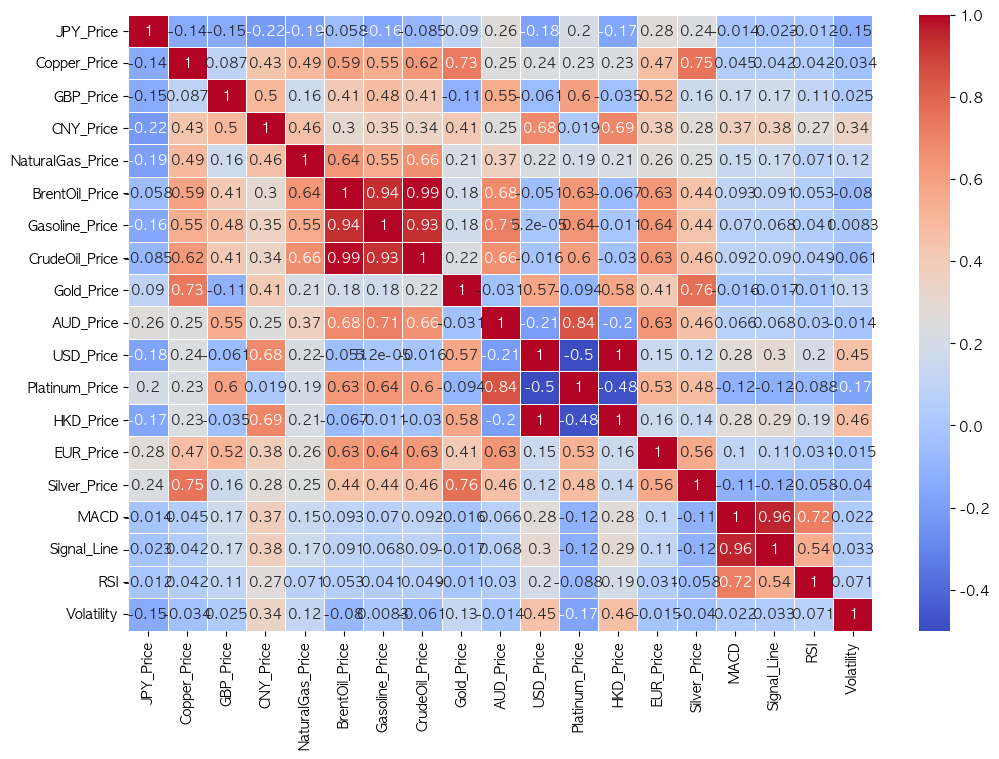

In [49]:
#상관관계 시각화
plt.figure(figsize=(12, 8))  # 히트맵의 크기 설정
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.show()
#plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

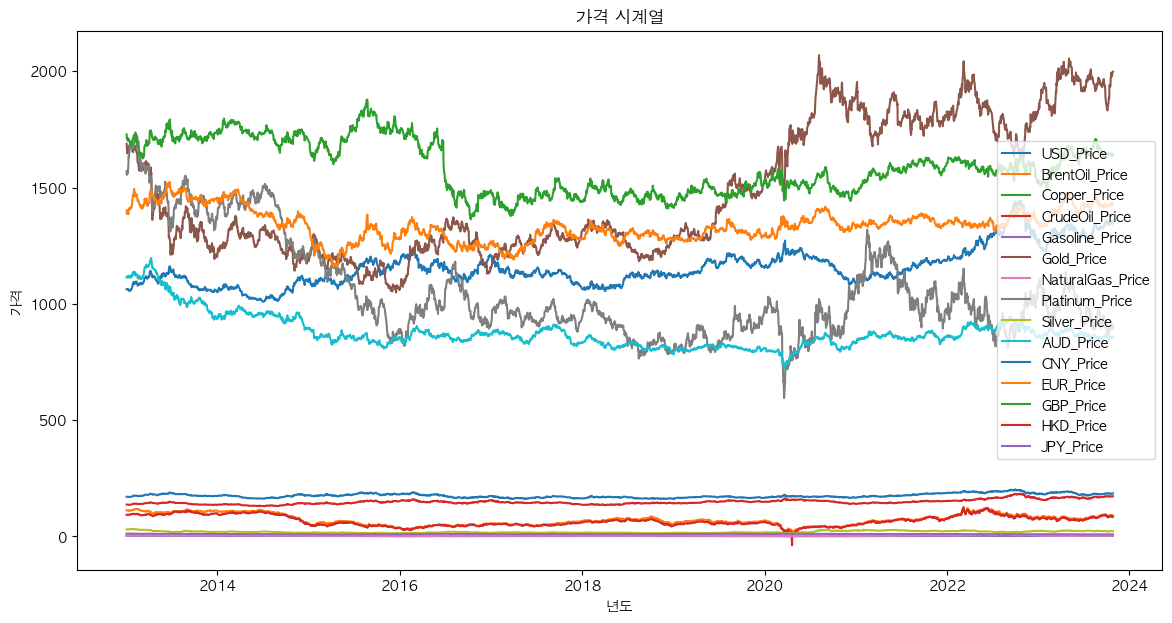

In [50]:
plt.figure(figsize=(14, 7))
for col in in_columns:
    if 'Price' in col:
        plt.plot(df[col], label=col)
plt.title('가격 시계열')
plt.xlabel('년도')
plt.ylabel('가격')
plt.legend()
plt.show()

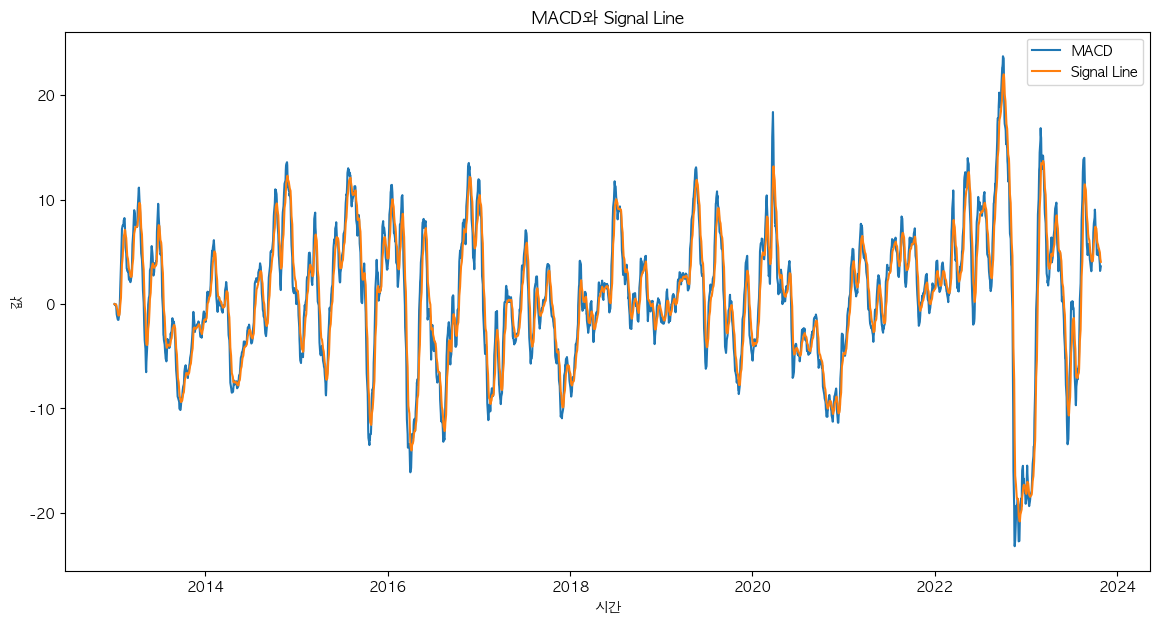

In [51]:
# 시각화 - MACD와 Signal Line
plt.figure(figsize=(14, 7))
plt.plot(df['MACD'], label='MACD')
plt.plot(df['Signal_Line'], label='Signal Line')
plt.title('MACD와 Signal Line')
plt.xlabel('시간')
plt.ylabel('값')
plt.legend()
plt.show()



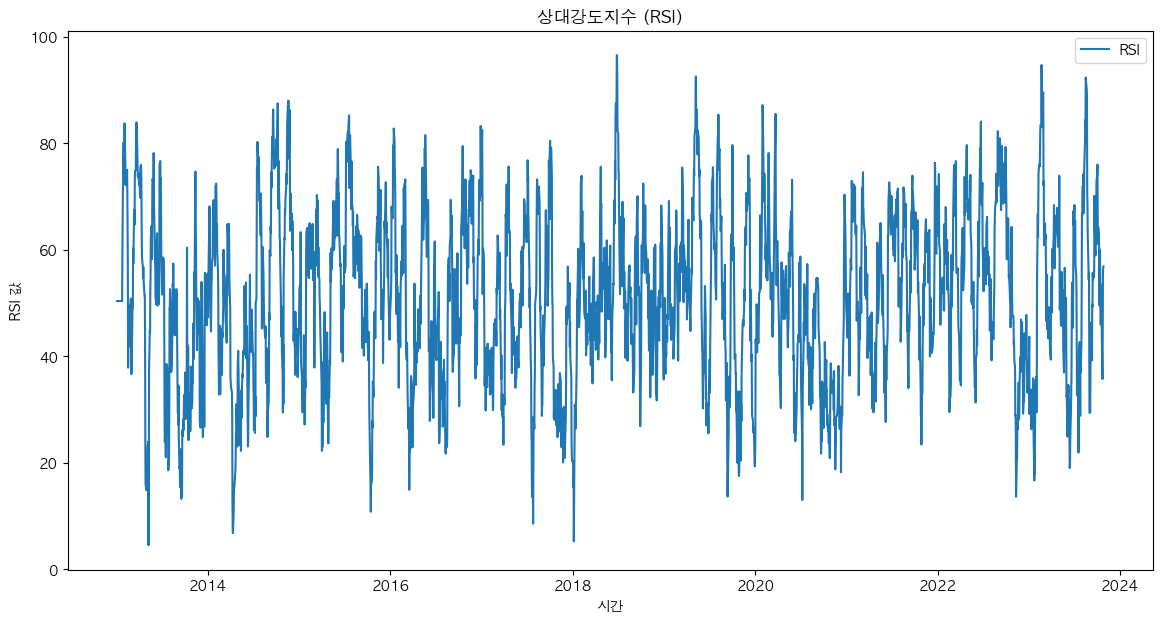

In [52]:
# 시각화 - RSI
plt.figure(figsize=(14, 7))
plt.plot(df['RSI'], label='RSI')
plt.title('상대강도지수 (RSI)')
plt.xlabel('시간')
plt.ylabel('RSI 값')
plt.legend()
plt.show()



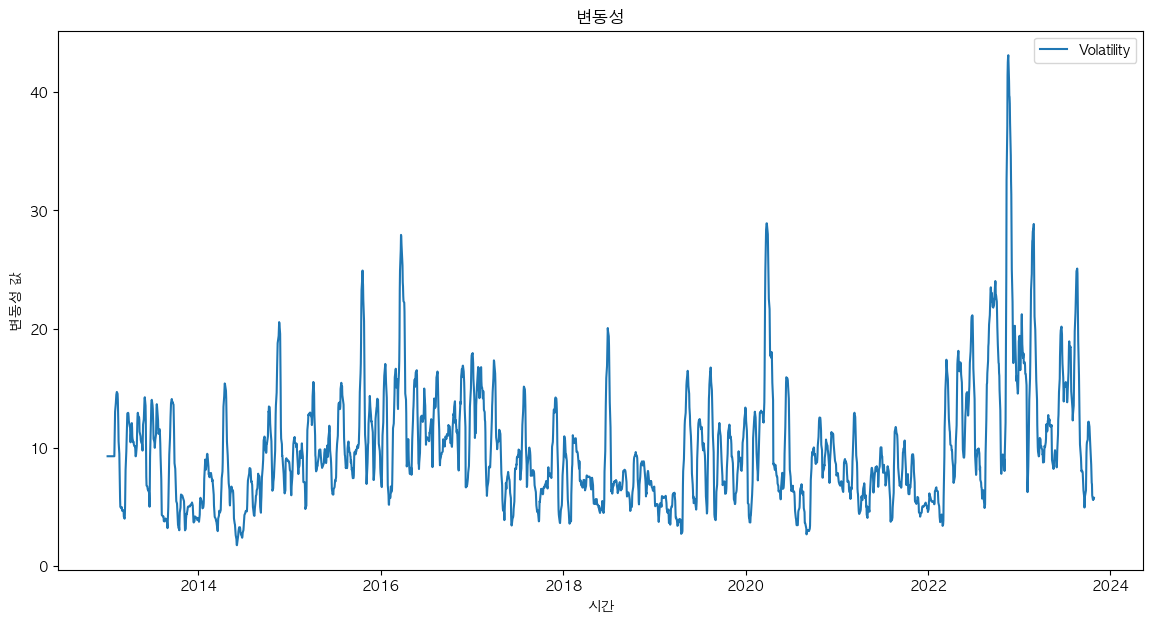

In [53]:
# 시각화 - 변동성
plt.figure(figsize=(14, 7))
plt.plot(df['Volatility'], label='Volatility')
plt.title('변동성')
plt.xlabel('시간')
plt.ylabel('변동성 값')
plt.legend()
plt.show()

# 모든 데이터를 random으로 섞음
## 시계열 데이터가 아닌 변수들의 관계만으로 USD_Price를 예측하도록 함

In [54]:
df = df.sample(frac=1).reset_index(drop=True)

In [55]:
df

,JPY_Price,Copper_Price,GBP_Price,CNY_Price,NaturalGas_Price,BrentOil_Price,Gasoline_Price,CrudeOil_Price,Gold_Price,AUD_Price,USD_Price,Platinum_Price,HKD_Price,EUR_Price,Silver_Price,MACD,Signal_Line,RSI,Volatility
0,10.6727,3.5800,1526.27,172.48,2.664,55.53,1.3929,52.34,1841.2,854.30,1112.52,1076.50,143.500,1348.49,25.922,2.434254,0.469316,67.694994,7.772660
1,10.2997,4.3590,1607.97,183.32,5.426,84.38,2.0329,83.57,1783.9,883.32,1174.47,1021.70,150.980,1357.80,23.949,-2.024367,-0.001441,32.021405,9.420387
2,11.0057,2.1800,1460.11,167.72,2.834,44.29,1.3680,41.93,1367.4,849.72,1113.94,1161.55,143.615,1239.71,20.443,-11.289175,-9.539349,32.380680,13.415653
3,11.1599,2.0945,1704.93,176.36,2.747,50.65,1.5827,49.37,1292.1,865.05,1159.89,987.10,149.455,1312.31,17.514,-1.402839,-0.052443,32.711688,12.508881
4,9.3306,2.5515,1741.36,182.36,2.726,58.61,2.0451,52.78,1159.2,843.16,1132.22,1022.65,146.055,1249.80,15.361,6.789202,5.344541,78.823997,10.029453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2775,10.1432,2.6520,1413.51,167.48,2.901,56.01,1.6723,53.20,1225.5,875.49,1155.15,980.60,148.775,1222.33,17.773,-3.586717,-6.626212,62.695191,7.045860
2776,10.2282,3.0940,1454.49,170.69,3.040,52.38,2.1399,47.23,1322.2,893.92,1124.86,1001.25,143.735,1339.70,17.575,-2.023594,-0.648024,30.670103,7.791916
2777,10.9456,2.5105,1545.89,169.59,1.819,54.45,1.2990,50.11,1582.4,796.09,1189.79,971.30,153.200,1315.67,17.670,5.797412,2.182439,78.542652,11.912132
2778,10.0935,2.9700,1475.53,169.30,2.517,71.62,1.6140,63.76,1276.8,812.03,1131.28,892.70,144.190,1277.67,14.939,1.316496,2.171449,44.753988,3.255179


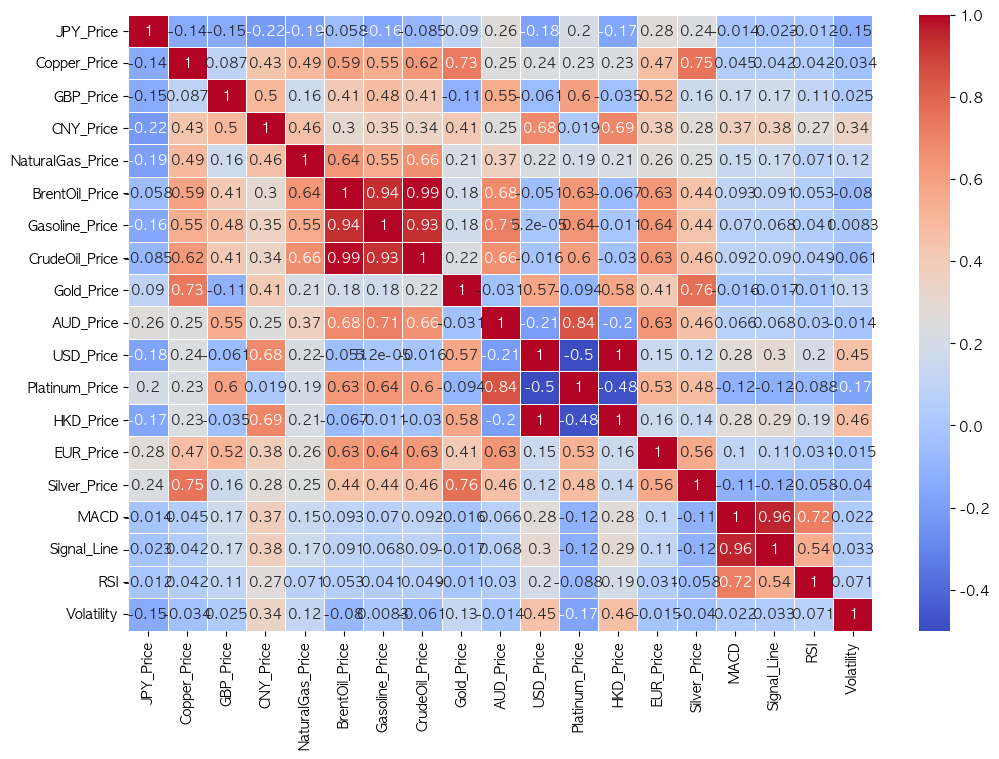

In [56]:
#상관관계 시각화
plt.figure(figsize=(12, 8))  # 히트맵의 크기 설정
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.show()
#plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [57]:
df

,JPY_Price,Copper_Price,GBP_Price,CNY_Price,NaturalGas_Price,BrentOil_Price,Gasoline_Price,CrudeOil_Price,Gold_Price,AUD_Price,USD_Price,Platinum_Price,HKD_Price,EUR_Price,Silver_Price,MACD,Signal_Line,RSI,Volatility
0,10.6727,3.5800,1526.27,172.48,2.664,55.53,1.3929,52.34,1841.2,854.30,1112.52,1076.50,143.500,1348.49,25.922,2.434254,0.469316,67.694994,7.772660
1,10.2997,4.3590,1607.97,183.32,5.426,84.38,2.0329,83.57,1783.9,883.32,1174.47,1021.70,150.980,1357.80,23.949,-2.024367,-0.001441,32.021405,9.420387
2,11.0057,2.1800,1460.11,167.72,2.834,44.29,1.3680,41.93,1367.4,849.72,1113.94,1161.55,143.615,1239.71,20.443,-11.289175,-9.539349,32.380680,13.415653
3,11.1599,2.0945,1704.93,176.36,2.747,50.65,1.5827,49.37,1292.1,865.05,1159.89,987.10,149.455,1312.31,17.514,-1.402839,-0.052443,32.711688,12.508881
4,9.3306,2.5515,1741.36,182.36,2.726,58.61,2.0451,52.78,1159.2,843.16,1132.22,1022.65,146.055,1249.80,15.361,6.789202,5.344541,78.823997,10.029453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2775,10.1432,2.6520,1413.51,167.48,2.901,56.01,1.6723,53.20,1225.5,875.49,1155.15,980.60,148.775,1222.33,17.773,-3.586717,-6.626212,62.695191,7.045860
2776,10.2282,3.0940,1454.49,170.69,3.040,52.38,2.1399,47.23,1322.2,893.92,1124.86,1001.25,143.735,1339.70,17.575,-2.023594,-0.648024,30.670103,7.791916
2777,10.9456,2.5105,1545.89,169.59,1.819,54.45,1.2990,50.11,1582.4,796.09,1189.79,971.30,153.200,1315.67,17.670,5.797412,2.182439,78.542652,11.912132
2778,10.0935,2.9700,1475.53,169.30,2.517,71.62,1.6140,63.76,1276.8,812.03,1131.28,892.70,144.190,1277.67,14.939,1.316496,2.171449,44.753988,3.255179


In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
# 특징과 타겟 분할
# StandardScaler 객체 생성
scaler = StandardScaler()

# 전체 데이터를 정규화
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
X = df.drop(columns=['USD_Price']) 
y = df['USD_Price'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [62]:
X_train

,JPY_Price,Copper_Price,GBP_Price,CNY_Price,NaturalGas_Price,BrentOil_Price,Gasoline_Price,CrudeOil_Price,Gold_Price,AUD_Price,Platinum_Price,HKD_Price,EUR_Price,Silver_Price,MACD,Signal_Line,RSI,Volatility
1017,1.849765,-0.880350,-0.875880,-0.503734,-0.887215,-0.537730,-0.997000,-0.570004,0.217957,-0.792323,-0.895346,0.598239,0.184666,-0.526760,0.924310,1.159025,-0.254049,0.228555
1632,2.310440,0.758220,0.987863,-0.640585,0.014456,1.708630,1.365001,1.246584,0.687253,3.186170,2.833589,-1.220476,1.079923,2.863368,-0.303677,-0.196596,-0.041106,-0.113258
1208,0.169170,-1.240999,0.757689,0.340372,-1.046725,-1.298774,-0.873006,-1.204924,-0.752682,0.073097,-0.299138,0.035433,-0.455675,-0.868322,-1.512768,-0.558810,-2.296104,2.679173
1538,-0.772034,2.394554,0.152469,1.915883,2.690668,1.576088,1.268052,1.706071,1.809933,0.441138,-0.289775,0.739931,-0.104221,1.606023,0.393659,0.330131,0.089648,-0.562713
2137,0.237182,0.235129,1.696194,-0.003481,2.064446,1.648345,1.485083,1.663349,-0.555421,1.084742,1.702736,-1.105042,1.812591,0.571436,-0.218414,0.088711,-1.154748,-0.396561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.824842,-0.058457,-0.989320,-0.556634,-0.412379,-1.252598,-1.237333,-1.176291,1.550004,-0.971251,-0.880131,-0.145894,0.039497,1.276341,-1.503541,-1.413656,-1.595820,0.213425
1095,2.105070,0.352117,1.124988,0.687674,0.438337,1.471766,1.610948,1.206589,0.270655,3.953749,2.200162,-0.363386,1.687745,1.788437,1.075841,1.080313,1.195420,0.121819
1130,0.637846,-1.596433,1.394163,1.336279,-1.071094,-1.698963,-1.667994,-1.712132,-0.954928,-0.150864,-0.541648,0.779565,0.285703,-1.038609,0.483658,0.434959,0.260931,-0.505004
1294,0.189915,1.798440,-0.264872,1.070627,0.340121,0.107019,-0.016447,0.192172,1.069313,-0.480976,-0.528539,0.250449,-0.120479,0.611780,-0.238091,-0.064625,-0.428420,-0.959072


In [63]:
X_test

,JPY_Price,Copper_Price,GBP_Price,CNY_Price,NaturalGas_Price,BrentOil_Price,Gasoline_Price,CrudeOil_Price,Gold_Price,AUD_Price,Platinum_Price,HKD_Price,EUR_Price,Silver_Price,MACD,Signal_Line,RSI,Volatility
1561,2.298882,0.476556,0.885910,0.409372,0.377783,1.550008,1.889721,1.277034,0.456166,3.812082,2.522259,-0.532823,1.310596,2.295335,1.191440,1.018281,1.625465,0.619267
1099,-1.256861,-1.322965,1.463527,0.772775,-0.777922,-1.057207,-0.988325,-1.038127,-1.382565,-0.824892,-0.627088,0.090425,-1.350496,-1.269287,-0.667328,-1.280619,0.889886,-0.223497
1455,0.869147,0.191911,1.109851,-0.094331,0.122272,1.348631,0.938083,1.249311,-0.597793,1.707035,1.897493,-1.128327,1.283014,0.523667,-0.692799,-0.899359,0.304002,-1.240483
911,-0.080355,-0.847564,-1.008375,-0.336983,-0.063822,-0.660866,-0.519905,-0.611362,-1.107681,-0.092026,-0.485702,0.561577,-1.219844,-0.739865,1.504844,1.545557,1.285800,1.529046
521,0.806024,-1.586001,1.317764,0.686524,-0.970662,-0.987943,-0.540316,-0.843151,-0.789001,-0.266664,-0.156816,0.426325,-0.121060,-0.754468,1.002751,0.488805,1.543921,1.207892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,-0.574517,-1.313278,2.154494,1.052227,-0.487703,-1.230365,-1.014859,-1.277642,-1.252600,-0.475480,-0.311779,0.401554,0.001753,-1.361360,1.446761,1.599665,0.809176,0.035629
2102,-0.833971,-0.091989,-1.105609,-1.220189,-0.494350,-0.367992,-0.477724,-0.439566,-0.780812,-0.578280,-0.789307,-0.898448,-0.809887,-0.892826,-0.944501,-1.229036,0.128170,-1.098825
941,-0.128216,-0.252940,-0.576342,-0.353083,-0.323025,-0.675402,-0.674004,-0.733165,-0.714227,0.258860,-0.632940,-0.178592,0.096693,-0.714620,0.465536,0.221071,1.873231,-0.752531
647,-0.827599,0.434828,0.371067,2.701338,1.362901,0.824879,0.769016,0.812093,0.632775,0.447840,-0.584719,3.513335,1.274014,-0.087185,1.724499,2.098952,0.845577,-0.235323


In [76]:
y_train

1017    0.679454
1632   -1.239757
1208   -0.029927
1538    0.809359
2137   -1.126689
          ...   
1638   -0.212802
1095   -0.398750
1130    0.756266
1294    0.255325
860    -0.978717
Name: USD_Price, Length: 1946, dtype: float64

In [77]:
y_test

1561   -0.563805
1099    0.017390
1455   -1.154710
911     0.476545
521     0.369991
          ...   
1712    0.317390
2102   -0.837627
941    -0.132180
647     3.530371
2444    0.113006
Name: USD_Price, Length: 834, dtype: float64

In [64]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = DecisionTreeRegressor()


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)


mse = mean_squared_error(y_test, y_pred)


r_squared = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R-squared: {r_squared}')


MAE: 0.02238361608685048
MSE: 0.0012585170294862184
R-squared: 0.9987228247876843


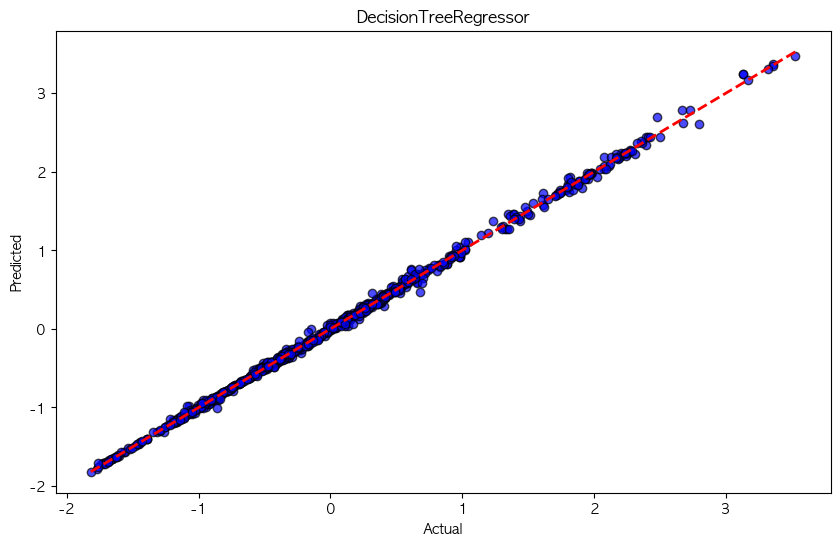

In [65]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('DecisionTreeRegressor')
plt.show()

In [79]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# 하이퍼파라미터 그리드 설정
param_grid_tree = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV 객체 생성
grid_search_tree = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42), param_grid=param_grid_tree, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')


Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree R² (Train): 0.9999170014408767
Decision Tree R² (Test): 0.9987728476622205
Decision Tree MSE (Train): 8.351166079997585e-05
Decision Tree MSE (Test): 0.0012092249363882888


In [82]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2, random_state=42)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)


mse = mean_squared_error(y_test, y_pred)


r_squared = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R-squared: {r_squared}')


MAE: 0.022417958570808905
MSE: 0.0012092249363882888
R-squared: 0.9987728476622205


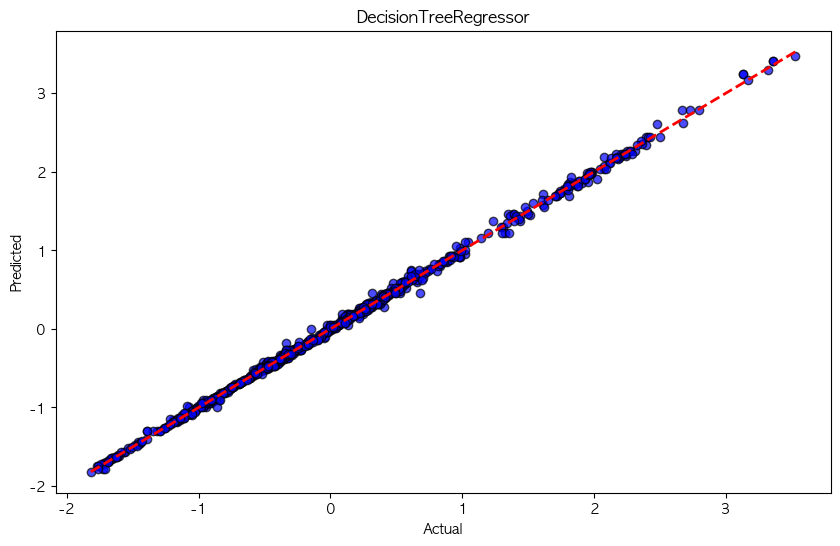

In [83]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('DecisionTreeRegressor')
plt.show()

In [66]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)


mse = mean_squared_error(y_test, y_pred)


r_squared = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R-squared: {r_squared}')



MAE: 0.015845591639588805
MSE: 0.0006195918959568731
R-squared: 0.9993712223253817


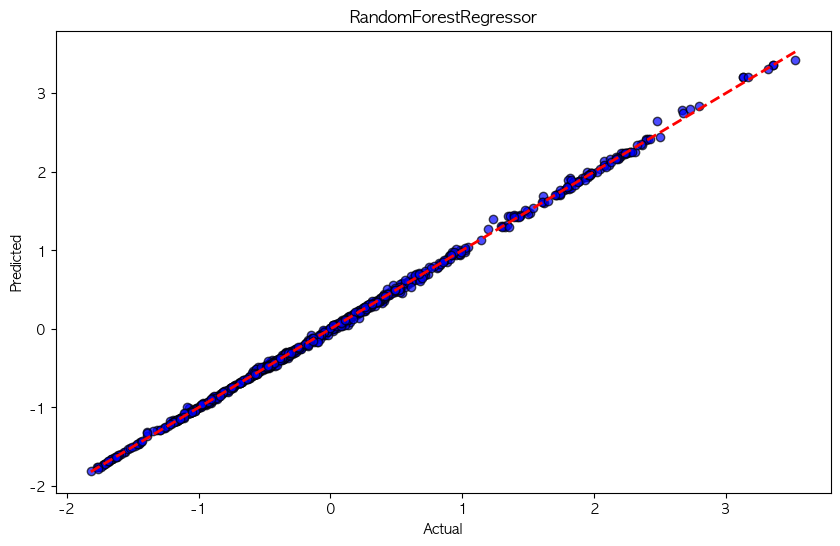

In [67]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('RandomForestRegressor')
plt.show()

In [68]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)


mse = mean_squared_error(y_test, y_pred)


r_squared = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R-squared: {r_squared}')

MAE: 0.025179727119657824
MSE: 0.0010839697573603803
R-squared: 0.9988999598157478


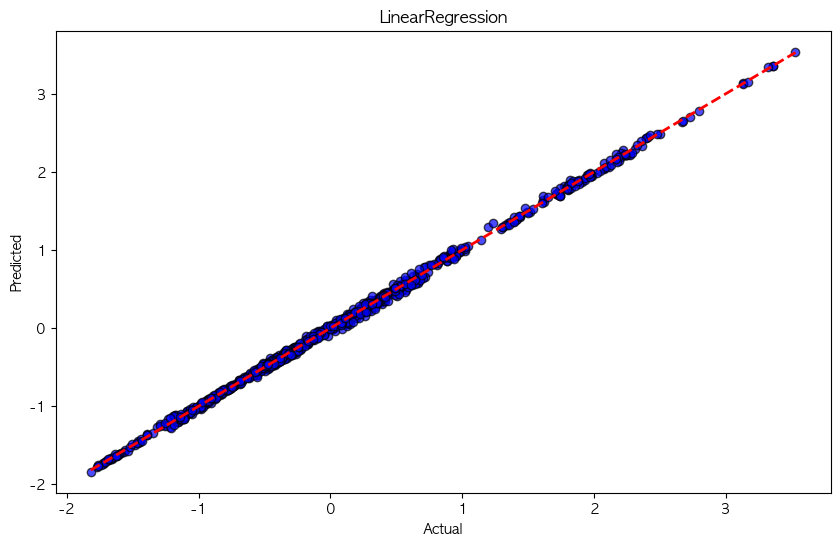

In [69]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('LinearRegression')
plt.show()

In [81]:
from sklearn.linear_model import Ridge

# 하이퍼파라미터 그리드 설정
param_grid_linear = {
    'alpha': [0.1, 1, 10, 100] 
}

# GridSearchCV 객체 생성
grid_search_linear = GridSearchCV(estimator=Ridge(), param_grid=param_grid_linear, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

# 모델 학습
grid_search_linear.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print(f'Best parameters for Linear Regression (Ridge): {grid_search_linear.best_params_}')

# 최적의 모델로 예측
best_linear_model = grid_search_linear.best_estimator_
y_pred_train_linear = best_linear_model.predict(X_train)
y_pred_test_linear = best_linear_model.predict(X_test)

# 평가
r2_train_linear = r2_score(y_train, y_pred_train_linear)
r2_test_linear = r2_score(y_test, y_pred_test_linear)
mse_train_linear = mean_squared_error(y_train, y_pred_train_linear)
mse_test_linear = mean_squared_error(y_test, y_pred_test_linear)

print(f'Linear Regression (Ridge) R² (Train): {r2_train_linear}')
print(f'Linear Regression (Ridge) R² (Test): {r2_test_linear}')
print(f'Linear Regression (Ridge) MSE (Train): {mse_train_linear}')
print(f'Linear Regression (Ridge) MSE (Test): {mse_test_linear}')


Best parameters for Linear Regression (Ridge): {'alpha': 0.1}
Linear Regression (Ridge) R² (Train): 0.9989026032897309
Linear Regression (Ridge) R² (Test): 0.9988993995551757
Linear Regression (Ridge) MSE (Train): 0.001104180877342801
Linear Regression (Ridge) MSE (Test): 0.0010845218331163812


In [70]:
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

model.fit(X_train, y_train)

mae = mean_absolute_error(y_test, y_pred)


mse = mean_squared_error(y_test, y_pred)


r_squared = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R-squared: {r_squared}')

MAE: 0.025179727119657824
MSE: 0.0010839697573603803
R-squared: 0.9988999598157478


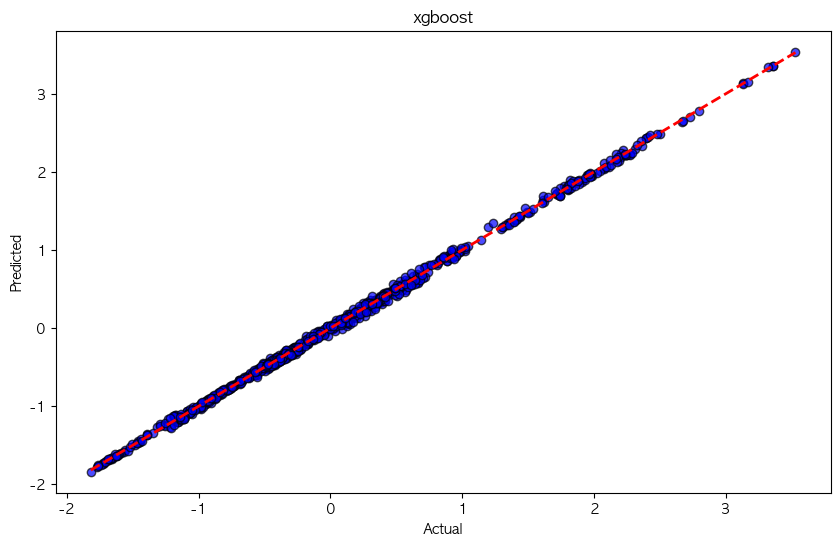

In [71]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('xgboost')
plt.show()

In [73]:
!pip install lightgbm

  Using cached lightgbm-4.3.0-py3-none-macosx_14_0_arm64.whl


In [74]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=100)
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='l1')

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
mae = mean_absolute_error(y_test, y_pred)


mse = mean_squared_error(y_test, y_pred)


r_squared = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R-squared: {r_squared}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1946, number of used features: 18
[LightGBM] [Info] Start training from score -0.004866
MAE: 0.016621510282937624
MSE: 0.0006715424720109061
R-squared: 0.9993185015544687


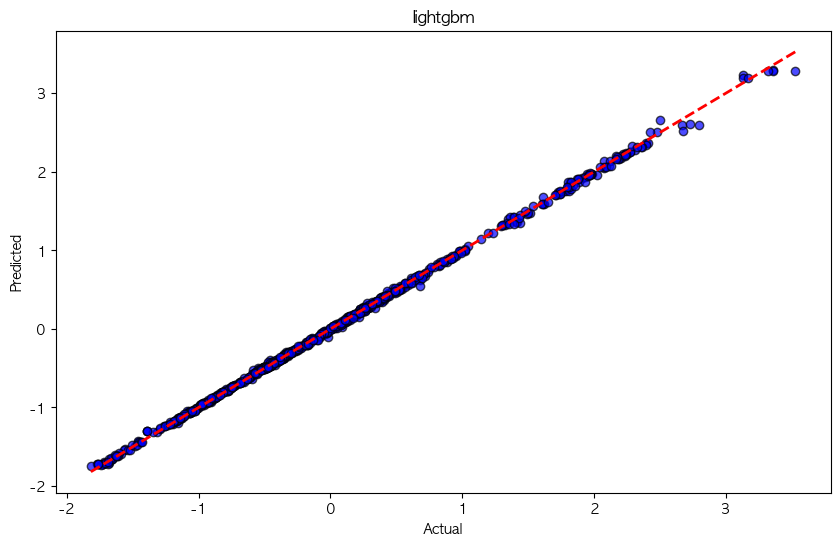

In [75]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('lightgbm')
plt.show()

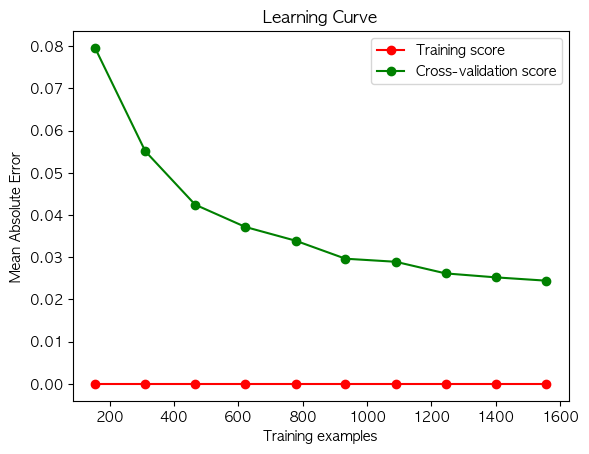

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    DecisionTreeRegressor(random_state=42), 
    X_train, 
    y_train, 
    n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 10), 
    scoring='neg_mean_absolute_error'
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Mean Absolute Error")
plt.legend(loc="best")
plt.show()